### Генерация поэзии с помощью нейронных сетей: шаг 1
##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

Ваша основная задача: научиться генерироват стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [42]:
# do not change the code in the block below
# __________start of block__________
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
# __________end of block__________

In [43]:
# do not change the code in the block below
# __________start of block__________
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))
# __________end of block__________

cpu device is available


#### 1. Загрузка данных.

In [44]:
# do not change the code in the block below
# __________start of block__________
!wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = "".join([x.replace('\t\t', '').lower() for x in text])
# __________end of block__________

--2024-11-04 23:42:50--  https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 262521 (256K) [text/plain]
Сохранение в: «onegin.txt.3»

onegin.txt.3        100%[===================>] 256,37K   488KB/s    за 0,5s    

2024-11-04 23:42:52 (488 KB/s) - «onegin.txt.3» сохранён [262521/262521]



#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим токен `<sos>`.

In [45]:
# do not change the code in the block below
# __________start of block__________
tokens = sorted(set(text.lower())) + ['<sos>']
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]
# __________end of block__________

Seems fine!


__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете воспользоваться кодом с занятие №6 или же обратиться к следующим ссылкам:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Данное задание является достаточно творческим. Не страшно, если поначалу оно вызывает затруднения. Последняя ссылка в списке выше может быть особенно полезна в данном случае.

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Вы можете использовать его при обучении модели.

In [46]:
# do not change the code in the block below
# __________start of block__________
batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))
# __________end of block__________    

Пример батча:

In [47]:
next(generate_chunk())

array([[83,  1, 62, ..., 43, 60, 59],
       [83, 61, 45, ...,  1, 74, 63],
       [83, 59,  1, ..., 51,  1, 62],
       ...,
       [83, 56, 72, ...,  5,  0, 61],
       [83, 45, 62, ..., 63, 62, 76],
       [83,  1, 63, ..., 60, 64, 62]])

Далее вам предстоит написать код для обучения модели и генерации текста.

In [48]:
# your beautiful experiments here
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
# Теперь определим модель Vanilla RNN для предсказания следующего символа.
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(VanillaRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        x = self.embedding(x)
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        return out, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size)


In [49]:
# Теперь создадим функцию для подготовки входных данных и целевых меток для модели.
def prepare_batch(batch_data):
    input_data = torch.tensor(batch_data[:, :-1], dtype=torch.long)
    target_data = torch.tensor(batch_data[:, 1:], dtype=torch.long)
    return input_data, target_data


In [50]:
# Зададим параметры и начнем процесс обучения.

# Гиперпараметры
hidden_size = 512           # Увеличим размер скрытого слоя
num_epochs = 10000          # Зададим большое число эпох
learning_rate = 0.0001      # Очень маленькая скорость обучения

# Инициализация модели, функции потерь и оптимизатора
model = VanillaRNN(num_tokens, hidden_size, num_tokens)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Список для сохранения значений функции потерь
loss_values = []

# Обучение
for epoch in range(num_epochs):
    epoch_loss = 0  # для суммирования потерь в течение эпохи
    batch_count = 0  # для подсчета батчей в эпохе
    
    for batch in generate_chunk():
        inputs, targets = prepare_batch(batch)
        
        hidden = model.init_hidden(batch_size)
        optimizer.zero_grad()
        
        outputs, hidden = model(inputs, hidden)
        
        # Изменение размеров для потерь
        loss = criterion(outputs.view(-1, num_tokens), targets.view(-1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        batch_count += 1  # увеличиваем счетчик батчей
    
    average_epoch_loss = epoch_loss / batch_count  # средняя потеря за эпоху
    loss_values.append(average_epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_epoch_loss:.4f}")



Epoch [1/10000], Loss: 4.4854
Epoch [2/10000], Loss: 4.4446
Epoch [3/10000], Loss: 4.3998
Epoch [4/10000], Loss: 4.3571
Epoch [5/10000], Loss: 4.3146
Epoch [6/10000], Loss: 4.2730
Epoch [7/10000], Loss: 4.2273
Epoch [8/10000], Loss: 4.1839
Epoch [9/10000], Loss: 4.1446
Epoch [10/10000], Loss: 4.0990
Epoch [11/10000], Loss: 4.0513
Epoch [12/10000], Loss: 4.0052
Epoch [13/10000], Loss: 3.9567
Epoch [14/10000], Loss: 3.8947
Epoch [15/10000], Loss: 3.8519
Epoch [16/10000], Loss: 3.7987
Epoch [17/10000], Loss: 3.7381
Epoch [18/10000], Loss: 3.6937
Epoch [19/10000], Loss: 3.6423
Epoch [20/10000], Loss: 3.5751
Epoch [21/10000], Loss: 3.5112
Epoch [22/10000], Loss: 3.4453
Epoch [23/10000], Loss: 3.4144
Epoch [24/10000], Loss: 3.3537
Epoch [25/10000], Loss: 3.3273
Epoch [26/10000], Loss: 3.2928
Epoch [27/10000], Loss: 3.2630
Epoch [28/10000], Loss: 3.2403
Epoch [29/10000], Loss: 3.2022
Epoch [30/10000], Loss: 3.1966
Epoch [31/10000], Loss: 3.1594
Epoch [32/10000], Loss: 3.1446
Epoch [33/10000],

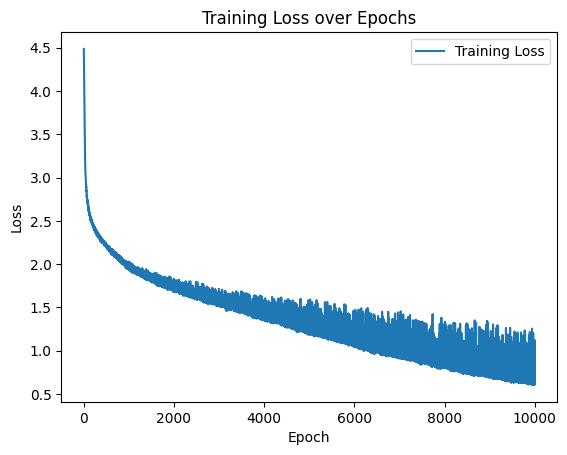

In [51]:
# Построение графика функции потерь
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs + 1), loss_values, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.show()


In [52]:
import torch.nn.functional as F

def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device='cpu'):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    # Преобразуем начальную фразу в индексы, добавив токен начала последовательности
    if seed_phrase is not None:
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
    else: 
        x_sequence = [token_to_idx['<sos>']]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    
    # Инициализируем скрытое состояние
    hidden = char_rnn.init_hidden(batch_size=1).to(device)

    # Пропускаем начальную фразу через RNN
    for i in range(x_sequence.shape[1] - 1):
        _, hidden = char_rnn(x_sequence[:, i:i+1], hidden)
    
    # Начинаем генерацию текста
    generated_text = seed_phrase if seed_phrase is not None else ""
    current_input = x_sequence[:, -1:]  # Последний символ начальной фразы

    for _ in range(max_length - len(generated_text)):
        output, hidden = char_rnn(current_input, hidden)
        output = output[:, -1, :] / temperature  # Adjust with temperature
        probabilities = F.softmax(output, dim=-1).cpu().data.numpy().flatten()

        # Sample next character index
        next_char_idx = np.random.choice(range(len(tokens)), p=probabilities)
        generated_text += idx_to_token[next_char_idx]
        
        # Prepare the next input
        current_input = torch.tensor([[next_char_idx]], dtype=torch.int64).to(device)
    
    return generated_text


In [53]:
print(generate_sample(model, ' мой дядя самых честных правил', max_length=500, temperature=0.8))

 мой дядя самых честных правилах девы
и прервал на два шаю?



xxx

свой модных людей сон залев…


ix

може сорвал с твоействии кружит…
«могда пламенной дев,
тамят что не замечает,
порой не обрателя неневно,
вашний изнымец, негойдет
и смороки и в свечерь.



xxxiv

татьяна в вокренских досуги,
полей загрузья;
письмо нежный хоровой.



xlv

но дамская наз до похлубит.
насметлены любовь
не изумленьем шуток.
враги! давно едет он еетельное все хори,
зимой души не изменили
у ней луна сидит,
не думала


### ПРИМЕРЫ КАК ДОЛЖНО БЫТЬ

В качестве иллюстрации ниже доступен график значений функции потерь, построенный в ходе обучения авторской сети (сам код для ее обучения вам и предстоит написать).

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

In [12]:
def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    if seed_phrase is not None:
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
    else: 
        x_sequence = [token_to_idx['<sos>']]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    
    #feed the seed phrase, if any
            
    # your code here
    
    return ''.join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])

Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [22]:
print(generate_sample(model, ' мой дядя самых честных правил', max_length=500, temperature=0.8))

<sos> мой дядя самых честных правилас;



xiv

но как потокой.



xii

«я свобред не словавран в скорей,
для с посвялесь мне моловой,
те ты,
перегиной в тям праздной
и привезут перваю вся вновся сквозь ти стала сблился,
и старый свимарной таня обратель любова не когда и нет волностье нежной
тишен,
перестоком.
«поже постаничив очествы
в и старько забаньем и заковенью,
ее своя моднать наводушта;
какой нет поли своем горозный и быле и, законно он ходушних недважный плая
с за стра.



xvii




xxvi

все 


### Сдача задания
Сгенерируйте десять последовательностей длиной 500, используя строку ' мой дядя самых честных правил'. Температуру для генерации выберите самостоятельно на основании визуального качества генериуремого текста. Не забудьте удалить все технические токены в случае их наличия.

Сгенерированную последовательность сохрание в переменную `generated_phrase` и сдайте сгенерированный ниже файл в контест.

In [54]:
seed_phrase = ' мой дядя самых честных правил'

In [55]:
generated_phrases = [
    generate_sample(
        model,
        seed_phrase=seed_phrase,
        max_length=500,
        temperature=0.8
    ).replace('<sos>', '')
    for _ in range(10)
]

# For example:

# generated_phrases = [
#     generate_sample(
#         model,
#         ' мой дядя самых честных правил',
#         max_length=500,
#         temperature=1.
#     ).replace('<sos>', '')
#     for _ in range(10)
# ]



In [56]:
for prase in generated_phrases:
    print("Prase")
    print (prase)
    

Prase
 мой дядя самых честных правила, и ножки милой
переные души брачах
я и бы вестных соседстве жена?»
«дляться очень наряд как
от красные поятел,
по марать летят ва все родного
на них одно гордости сам:
потом, что все триных;
и пьеш собенцему, тогда еще стало?
в фонегов доменье в умог.



xxviii

непостели всё дрожала о свету пера все хонилый
ее молодой тени
умол не вмин улыбкой,
всегда погрузяюсь евгений
пора припредает и шум
девошлиц, тогда, в тишине,
являться старой нас;
на модных кофо души моей
Prase
 мой дядя самых честных правила нога.
но таню, про луч делеи мой.



xxvi

еще приятнокам довор
на третье все умно и вор…
зачем до мы под венец
они сенерно, небрежно.



vii

ни я бысь врага
поспешна, живет татьяне писоканий
мальчиком в уколько своем лицо.



xx

умыль ба свет купает,
увершен весе
на долгих безурку, чем нежных,
чтобы просторожным кабилит;
случаюм: видом онегин подошел,
но тани трепетный умо.
они не шеленьемей, веселых,
в двух измерил разлуку,
татьяна беднеет сон.
но

In [57]:
print(generated_phrases[1])

 мой дядя самых честных правила нога.
но таню, про луч делеи мой.



xxvi

еще приятнокам довор
на третье все умно и вор…
зачем до мы под венец
они сенерно, небрежно.



vii

ни я бысь врага
поспешна, живет татьяне писоканий
мальчиком в уколько своем лицо.



xx

умыль ба свет купает,
увершен весе
на долгих безурку, чем нежных,
чтобы просторожным кабилит;
случаюм: видом онегин подошел,
но тани трепетный умо.
они не шеленьемей, веселых,
в двух измерил разлуку,
татьяна беднеет сон.
но взли желанит


In [58]:
# do not change the code in the block below
# __________start of block__________

import json
if 'generated_phrases' not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all([x in set(tokens) for x in set(list(phrase))]), 'Unknown tokens detected, check your submission!'
    

submission_dict = {
    'token_to_idx': token_to_idx,
    'generated_phrases': generated_phrases
}

with open('submission_dict.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict.json`')
# __________end of block__________

File saved to `submission_dict.json`


На этом задание завершено. Поздравляем!